In [3]:
# Import Libraries
#1264s
# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import time
from PIL import Image


# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Reshape, concatenate, Concatenate, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Cropping2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Warning
import warnings
warnings.filterwarnings("ignore")


In [4]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [5]:
# Configuration
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
NUM_CLASSES = 2
BATCH_SIZE = 8
EPOCHS = 200

In [6]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])

pd.set_option('max_colwidth',120)
df = pd.DataFrame({
    "_id" : data_map[::2],
    "path" : data_map[1::2]
})

df

,_id,path
0,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (208).png
1,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (13)_mask.png
2,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (176).png
3,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (97)_mask.png
4,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (172)_mask.png
...,...,...
1547,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (119)_mask.png
1548,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (107)_mask.png
1549,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (92).png
1550,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (103).png


In [7]:
df_images = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = len('/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (')
END_IMG_LEN = len(').png')
END_MASK_LEN = len(')_mask.png')

images = sorted(df_images["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

df_breast = pd.DataFrame({
    "_id": df_images._id.values,
    "image_path": images,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    return 0

df_breast["diagnosis"] = df_breast["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

df_breast

,_id,image_path,mask_path,diagnosis
0,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (1).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (1)_mask.png,1
1,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (1).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (1)_mask.png,1
2,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (1).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/normal/normal (1)_mask.png,0
3,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (2).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/malign/malign (2)_mask.png,1
4,malign,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (2).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (2)_mask.png,1
...,...,...,...,...
771,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (433).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (433)_mask.png,1
772,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (434).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (434)_mask.png,1
773,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (435).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (435)_mask.png,1
774,normal,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (436).png,/kaggle/input/breast-128-malign/new-new-breast-dataset/Dataset_BUSI_with_GT/benign/benign (436)_mask.png,1


In [8]:
df_breast_train = df_breast.drop(columns=['_id'])
df_breast_train, df_breast_test = train_test_split(df_breast_train, test_size=0.1, random_state=2023)

In [9]:
def get_data(img_path, mask_path):
    X_train = []
    Y_train = []

    for i in range(len(img_path)):
        img = cv2.imread(img_path[i])
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

        mask = cv2.imread(mask_path[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = np.expand_dims(mask, axis=-1)
        mask = mask / 255.

        X_train.append(img)
        Y_train.append(mask)

    return np.array(X_train), np.array(Y_train)

# Training Dataset
train_img_path = list(df_breast_train["image_path"])
train_mask_path = list(df_breast_train["mask_path"])

X_train, Y_train = get_data(train_img_path, train_mask_path)

# Testing Dataset
test_img_path = list(df_breast_test["image_path"])
test_mask_path = list(df_breast_test["mask_path"])

X_test, Y_test = get_data(test_img_path, test_mask_path)

In [10]:
# Loss and Metrics
def bce_loss(y_true, y_pred):
    y_true = tf.keras.backend.cast(y_true, 'float32')
    y_pred = tf.keras.backend.cast(y_pred, 'float32')
    
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    
    y_true_f = tf.keras.backend.cast(y_true_f, 'float32')
    y_pred_f = tf.keras.backend.cast(y_pred_f, 'float32')
    
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef_v = (2. * intersection + 1.) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1.)
    return dice_coef_v

def dice_loss(y_true, y_pred):
    dice_loss_v = 1 - dice_coef(y_true, y_pred)
    return dice_loss_v

def bce_dice_loss(y_true, y_pred):
    bce_dice_loss_v = bce_loss(y_true, y_pred) + dice_loss(y_true, y_pred)
    return bce_dice_loss_v

bce_dice_loss(tf.constant([1., 1., 0.9]), 
              tf.constant([1., 1., 1.]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.52560085>

In [11]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=200
)

In [12]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_densenet121_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained DenseNet121 Model """
    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = densenet.get_layer("input_1").output       ## 512
    s2 = densenet.get_layer("conv1/relu").output    ## 256
    s3 = densenet.get_layer("pool2_relu").output ## 128
    s4 = densenet.get_layer("pool3_relu").output  ## 64

    """ Bridge """
    b1 = densenet.get_layer("pool4_relu").output  ## 32

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)             ## 64
    d2 = decoder_block(d1, s3, 256)             ## 128
    d3 = decoder_block(d2, s2, 128)             ## 256
    d4 = decoder_block(d3, s1, 64)              ## 512

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model


In [13]:
input_shape = (128, 128, 3)
model = build_densenet121_unet(input_shape)

In [14]:
# Model Compiling
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss='binary_crossentropy', 
    metrics='accuracy'
)

In [15]:
# Callback
model_checkpoint = ModelCheckpoint(
    "densenet121_model.h5", 
    monitor="val_loss", 
    mode="min", 
    verbose=1,
    save_best_only=True
)
callbacks = [early_stopping, model_checkpoint]

In [16]:
history = model.fit(
    X_train, 
    Y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=1/9,
    callbacks=callbacks
)

Epoch 1/200
78/78 [==============================] - ETA: 0s - loss: 0.3472 - accuracy: 0.8935
Epoch 1: val_loss improved from inf to 326.48431, saving model to densenet121_model.h5
78/78 [==============================] - 74s 162ms/step - loss: 0.3472 - accuracy: 0.8935 - val_loss: 326.4843 - val_accuracy: 0.1531
Epoch 2/200
78/78 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9471
Epoch 2: val_loss improved from 326.48431 to 1.32595, saving model to densenet121_model.h5
78/78 [==============================] - 7s 94ms/step - loss: 0.1867 - accuracy: 0.9471 - val_loss: 1.3259 - val_accuracy: 0.8705
Epoch 3/200
78/78 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9533
Epoch 3: val_loss improved from 1.32595 to 0.30351, saving model to densenet121_model.h5
78/78 [==============================] - 8s 98ms/step - loss: 0.1485 - accuracy: 0.9533 - val_loss: 0.3035 - val_accuracy: 0.9053
Epoch 4/200
78/78 [==============================] - E

In [19]:
def plotOutput(history, className, epochs):
    k = ''
    if 'accuracy' in history.history :
        k = 'accuracy'    

    if 'acc' in history.history :
        k = 'acc'
    
    acc = history.history[k]
    val_acc = history.history['val_'+k]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

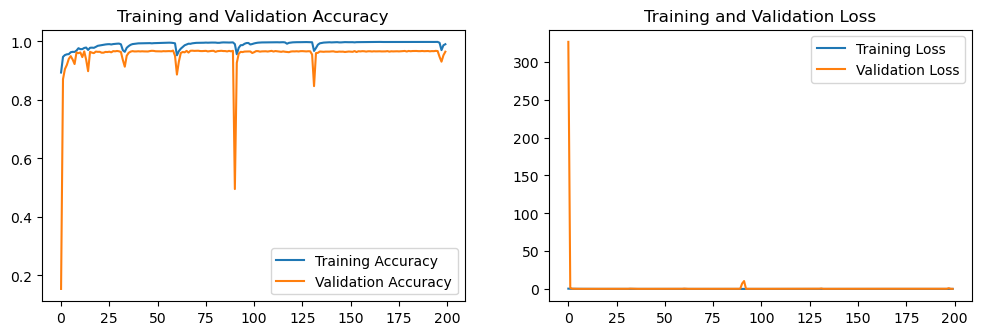

<Figure size 640x480 with 0 Axes>

In [20]:
plotOutput(history, 'Breast cancer', 200)